<a href="https://colab.research.google.com/github/vhaghani26/BST_227_Code/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The EM Algorithm for a more complex sequence model**
## By: Mariele Lensink and Viktoria Haghani

First, we need to import the modules we plan to use to run the code.

In [ ]:
import requests
import pandas as pd
import io
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import math

# **Core EM Code**

This section includes all the functions used in the EM implementation, including data preparation, random parameter initialization, the E-step, the M-step, and the log likelihood calculation.

Write a function to download and one-hot encoded the sequence data

In [ ]:
# Function written by Chenxi Liu (slight modifications made)

def get_sequence(url, categories=['A', 'C', 'G', 'T']):
  # Send a GET request to a specified URL, categories=['A', 'C', 'G', 'T']):
  r = requests.get(url)
  # Convert sequence data to data frame
  df = pd.read_csv(io.StringIO(r.text), sep=" ", header=None)
  # Turn the first sequence into a 2D array where each index is an independent array with a single base pair
  s1 = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  # Determine how many sequences there are in the text file
  num_seqs = len(df)
  # Assume all input sequences are equal length
  # Determine how long each sequence is
  seq_len = len(list(df.iloc[0, :].values)[0])
  # Start to make a one-hot encoded 3D matrix for the seqeunces
  # Not one-hot encoded yet, just zeroes 
  data = np.zeros((num_seqs, seq_len, len(categories)))
  # Make a matrix repersenting each category ['A', 'C', 'G', 'T']
  bp_counts = np.zeros((1, len(categories)))

  # Encode categorical feautures in a one-hot numeric array
  # Assign categories to be used
  ohe = OneHotEncoder(sparse=False, categories=[np.array(categories, dtype=object)])
  # Apply OneHotEncoder to example sequence
  ohe.fit(s1)
  
  # Apply OneHotEncoder to all sequences
  for ii in tqdm(range(num_seqs)):
    s = list(str(df.to_numpy()[ii, :][0]))
    s_a = np.array(s).reshape(-1, 1)
    data[ii, :, :] = ohe.transform(s_a)
  
  # Count the number of each base in the sequence data
  for ii in range(len(categories)):
    bp_counts[0,ii] = np.sum(data[:,:,ii])
  
  # Return the one-hot encoded matrix (data),
  # the counts for each base pair (bp_counts),
  # the number of sequences (N),
  # and the length of each sequence (L)
  return data, bp_counts                                                  

Write a modified version of the above function that returns a randomly split training and test data set

In [ ]:
# Function written by Chenxi Liu and Gerald Quon

def get_sequence_traintest(url, categories=['A', 'C', 'G', 'T'], FRACTION_TRAINING=0.8):
  # Send a GET request to a specified URL, categories=['A', 'C', 'G', 'T']):
  r = requests.get(url)
  # Convert sequence data to data frame
  df = pd.read_csv(io.StringIO(r.text), sep=" ", header=None)
  # Turn the first sequence into a 2D array where each index is an independent array with a single base pair
  s1 = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  # Determine how many sequences there are in the text file
  m = len(df)
  # Assume all input sequences are equal length
  # Determine how long each sequence is
  sequence_len = len(list(df.iloc[0, :].values)[0])
  # Start to make a one-hot encoded 3D matrix for the seqeunces
  # Not one-hot encoded yet, just zeroes 
  data = np.zeros((m, sequence_len, len(categories)))
  # Make a matrix repersenting each category ['A', 'C', 'G', 'T'] for the training set
  bp_counts_train = np.zeros((1, len(categories)))
  # Make a matrix repersenting each category ['A', 'C', 'G', 'T'] for the test set
  bp_counts_test = np.zeros((1, len(categories)))

  # Encode categorical feautures in a one-hot numeric array
  # Assign categories to be used
  ohe = OneHotEncoder(sparse=False, categories=[np.array(categories, dtype=object)])
  # Apply OneHotEncoder to example sequence
  ohe.fit(s1)

  # Apply OneHotEncoder to all sequences
  for ii in tqdm(range(m)):
    s = list(str(df.to_numpy()[ii, :][0]))
    s_a = np.array(s).reshape(-1, 1)
    data[ii, :, :] = ohe.transform(s_a)

  # Randomly permute rows of matrix
  np.random.shuffle(data)

  # Split data into training and text data
  train_indices = np.arange(start=0,stop=round(FRACTION_TRAINING*data.shape[0]))
  test_indices = np.arange(start=round(FRACTION_TRAINING*data.shape[0]), stop=data.shape[0])
  
  # Count the number of each base in the test and train sets
  for ii in range(len(categories)):
    bp_counts_train[0,ii] = np.sum(data[train_indices,:,ii])
    bp_counts_test[0,ii] = np.sum(data[test_indices,:,ii])
  
  # Return the base pair counts for the test and train sets
  return bp_counts_train, bp_counts_test

Write functions that will initialize our parameters

In [ ]:
# Make a function to randomly generate L - P + 1 lambdas that sum to 1
def initialize_lambda(sequence_length, motif_length):
  # Make an empty list to represent our parameter lambda_j
  lambda_j = []
  # Given our sequence length and motif length, determine how many lambdas we need
  lambdas = sequence_length - motif_length + 1
  # Fill up our empty matrix with the right number of lambdas using random probabilities
  for i in range(lambdas):
    lambda_j.append(np.random.random_sample())
  # Normalize probabilities by dividing each one by the sum
  # Need to set sum_lambdas on the outside of the for loop so it isn't recalculated every time
  sum_lambdas = sum(lambda_j)
  for i, lmbda in zip(range(lambdas), lambda_j):
    lambda_j[i] = (lmbda/sum_lambdas)
  # Return our lambda_j parameter
  return lambda_j

In [ ]:
# Make a function to randomly generate psi
# Psi is a 2D matrix: 4 x P (P = motif-length) 
# Each set of 4 corresponds to ['A', 'C', 'G', 'T']
def initialize_psi(motif_length):
  # Make a 4 x P matrix of zeroes
  psi = np.zeros((motif_length, 4), dtype = float)
  # For each sub-matrix of 4, generate probabilities that sum to 1
  for ind_i, i in zip(range(motif_length), psi):
    psi[ind_i] = (np.random.dirichlet(np.ones(4),size=1))
  # Return our psi parameter
  return psi

In [ ]:
# Store all initialized parameters in a dictionary called 'params' (params = theta)
def initialize_random_params(sequence_length, motif_length):
    params = {'lambda_j': initialize_lambda(sequence_length, motif_length),
              'psi0': initialize_psi(motif_length),
              'psi1': initialize_psi(motif_length)
              }
    return params

Write a function to calculate the posterior for the **E-step**

In [ ]:
def E_step(params,ohe_matrix,sequence_length,motif_length):
  posts = np.zeros((len(ohe_matrix),(sequence_length-motif_length)))
 #loop through every seqence in file 
  for i in range(len(ohe_matrix)):
    #loop through 
    for j in range(sequence_length - motif_length):
     #initialize C_ij 
      C_ij = np.log(params['lambda_j'][j])
      #compute P(X_ij|Cij = 1)
      for p in range(motif_length):
        for k in range(4):
          if ohe_matrix[i][j+p][k] != 0:
            C_ij = C_ij + np.log(ohe_matrix[i][j+p][k]*params['psi1'][p][k])
            posts[i][j] = C_ij
      for jprime in range(sequence_length-motif_length):
        if jprime == j:
          continue 
        for p in range(motif_length):
          for k in range(4):
            if ohe_matrix[i][j+p][k] != 0:
              C_ij = C_ij + np.log(ohe_matrix[i][j+p][k]*params['psi0'][p][k])
              posts[i][j] = C_ij
  posts1 = np.zeros((len(posts),len(posts[0])))
  for i in range(len(posts)):
    rowmin = posts[i].min()
    for j in range(len(posts[i])):
      posts1[i][j] = math.exp(posts[i][j] - rowmin)
      #posts1[i][j] = exp(posts1[i][j])
    rowsum = posts1[i].sum()
    for j in range(len(posts1[i])):
      posts1[i][j] = posts1[i][j]/rowsum
  # Return posterior matrix
  return posts1

# Test the E-step
posterior_matrix = E_step(params,my_ohe_at_gc_sequences,len(my_ohe_at_gc_sequences[0]),motif_length)
posterior_matrix

array([[6.09081522e-20, 1.14510121e-28, 9.89432681e-25, 6.28173461e-17,
        1.55952691e-10, 9.72954994e-59, 2.72123502e-28, 2.20549942e-39,
        1.83663562e-28, 1.95877754e-23, 1.62393237e-60, 1.01135675e-19,
        1.00000000e+00, 1.04133218e-12]])

Write a function to do the calculations for the **M-step**


We will start with making a practice posterior of random probabilities. This allows us to troubleshoot the M-step independent of the E-step. It does not get used in the EM algorithm implementation, but it's here for debugging purposes.

In [ ]:
# Make practice posterior to troubleshoot M-step

# Set the number of sequences
num_seqs = my_sequence_padded_num_seqs
# Set the length of the sequences
seq_len = my_sequence_padded_seq_len

practice_posterior = []
for i in range(num_seqs):
  new_row = initialize_lambda(seq_len, motif_length)
  practice_posterior.append(new_row)

print(len(practice_posterior)) # Should be total number of sequences; 357 for sequence padded
print(len(practice_posterior[0])) # Should be number of j's; 31 for sequence padded

357
21


In [ ]:
def M_step(onehot_matrix, posterior, motif_length): 
  # Make dictionary to store new parameters
  new_params = {}

  # Calculate new lambda_j
  # Add every column of the posterior
  column_sums = np.array(posterior).sum(axis = 0)
  # Divide by the total number of sequences
  new_lambda_j = (column_sums/(len(posterior))).tolist()
  # Confirm that the sum of our new_lambda_j is 1
  print(f'The sum of our new lambda_j is: {sum(new_lambda_j)}')
  # Add new_lambda_j to new_params
  new_params["lambda_j"] = new_lambda_j

  # Calculate new psi1
  # Determine how many j positions we have in our input matrix
  num_js = len(onehot_matrix[0]) - motif_length + 1
  # Determine matrix dimensions and save our window sequences
  X_ijmks = []
  for i, ind_i in zip(onehot_matrix, range(len(onehot_matrix))):
    # Iterate through the indeces for our lambda parameter
    for ind_j in range(num_js):
        # i[ind_j:ind_j+motif_length] is the base pair identities of the One-Hot encoded matrix within the window starting at j
        X_ijmk = (i[ind_j:ind_j+motif_length]).tolist()
        # Save each X_ijmk to the X_ijmks list for ease of access
        X_ijmks.append(X_ijmk)
  # Manipulate the posterior so it maches the X_ijmks list
  manipulated_posterior = []
  for i in posterior:
    for j in i:
      manipulated_posterior.append(j)
  # Make an empty list numerators, that will contain all the X_ijmks multiplied by C_ij    
  numerators = []
  for ind_post, X_ijmk in zip(range(len(manipulated_posterior)), X_ijmks):
    # Turn X_ijmk into an array
    X_ijmk_array = np.array(X_ijmk)
    # Multiply X_ijmk by the posterior (C_ij)
    numerator = X_ijmk_array * manipulated_posterior[ind_post]
    # Add the multiplied window sequences to the list "numerators"
    numerators.append(numerator)
  numerator_before_normalization = np.array(numerators).sum(axis = 0)
  new_psi1 = np.divide(numerator_before_normalization, len(onehot_matrix))
  # Verify that new_psi1 rows sum to 1
  print('The sums of each row in our new psi1 are:')
  for i in range(len(new_psi1)):
     print(sum(new_psi1[i]))
  # Add new_psi1 to new_params
  new_params["psi1"] = new_psi1.tolist()

  # Calculate new psi0
  # Determine how many j positions we have in our input matrix
  num_js = len(onehot_matrix[0]) - motif_length + 1
  # Determine matrix dimensions and save our window sequences
  X_ijmks = []
  for i, ind_i in zip(onehot_matrix, range(len(onehot_matrix))):
    # Iterate through the indeces for our lambda parameter
    for ind_j in range(num_js):
        # i[ind_j:ind_j+motif_length] is the base pair identities of the One-Hot encoded matrix within the window starting at j
        X_ijmk = (i[ind_j:ind_j+motif_length]).tolist()
        # Save each X_ijmk to the X_ijmks list for ease of access
        X_ijmks.append(X_ijmk)
  # Manipulate the posterior so it maches the X_ijmks list
  manipulated_posterior = []
  for i in posterior:
    for j in i:
      manipulated_posterior.append(j)
  # Make an empty list numerators, that will contain all the X_ijmks multiplied by C_ij    
  numerators = []
  for ind_post, X_ijmk in zip(range(len(manipulated_posterior)), X_ijmks):
    # Turn X_ijmk into an array
    X_ijmk_array = np.array(X_ijmk)
    # Multiply X_ijmk by 1 minus the posterior (C_ij)
    numerator = X_ijmk_array * (1 - manipulated_posterior[ind_post])
    # Add the multiplied window sequences to the list "numerators"
    numerators.append(numerator)
  numerator_before_normalization = np.array(numerators).sum(axis = 0)
  new_psi0 = np.divide(numerator_before_normalization, (len(onehot_matrix)*(len(onehot_matrix[0]) - motif_length + 1 - 1)))
  # Verify that new_psi0 rows sum to 1
  print('The sums of each row in our new psi0 are:')
  for i in range(len(new_psi0)):
     print(sum(new_psi0[i]))
  # Add new_psi1 to new_params
  new_params["psi0"] = new_psi0.tolist()
  
  # Save our new parameters as the output for the function
  return new_params

# Test the M-step
m_step_test = M_step(my_ohe_sequence_padded, practice_posterior, motif_length)
print(m_step_test['lambda_j'])
print(m_step_test['psi1'])
print(m_step_test['psi0'])

The sum of our new lambda_j is: 0.9999999999999999
The sums of each row in our new psi1 are:
1.0
1.0
1.0000000000000007
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999997
1.0
1.0000000000000002
1.0
1.0
0.9999999999999998
1.0
The sums of each row in our new psi0 are:
1.000000000000001
1.000000000000001
1.0000000000000013
1.000000000000001
1.0000000000000009
1.000000000000001
1.0000000000000009
1.0000000000000009
1.0000000000000009
1.0000000000000007
1.0000000000000009
1.0000000000000009
1.0000000000000009
1.0000000000000013
1.0000000000000009
1.0000000000000009
1.0000000000000007
1.0000000000000009
[0.0482344305716478, 0.047418511162571224, 0.0486489852737769, 0.04912840370383395, 0.04976002626812163, 0.04428026422248904, 0.049029635094488, 0.048961033462171184, 0.04865198947703092, 0.04542878578804531, 0.04627012068155647, 0.044662893368488756, 0.047643211893848667, 0.04672277676011

Write a function to compute the **log likelihood**

In [ ]:
#mariele's rough first shot at log likelihood
#relied heavlily on geralds code, so i think my ideas are right but instead we are going to need to use for loops to implement them 
#next try is going to go deeper into math, mostly hoping for something functional rn
# compute log likelihood, given posteriors based off the current parameter set theta (so KL = 0)
def loglikelihood(ohe_matrix, params, posteriors):
  #weighted probabilities
  weighted_log_joint_prob = (np.log(params['psi1'])+np.log(params['lambda_j']))*posteriors+((np.log(params['psi0'])+np.log(params['lambda_j']))*(1-posteriors))
  weighted_log_joint_prob[np.where(posteriors == 0)]=0; #putting in a check in case some posteriors are 0 (because some psi are 0) - 0log0 = 0 (otherwise we will get nan)
  
  expected_complete_LL = np.sum(weighted_log_joint_prob.T*ohe_matrix)
  #entropy 
  qlogq = posteriors * np.log(posteriors);
  qlogq[np.where(posteriors == 0)] = 0 #0log0 = 0
  return (expected_complete_LL - np.sum(np.sum(qlogq,axis=1) * ohe_matrix)) #log likelihood = ELBO + entropy, when q=p


# **Run EM**

Set data file URL locations

In [ ]:
# URL for at_gc_sequences.txt - this is a single sequence: ATTTAATATAAAATTTGGCCGCCATAAAAAAA
at_gc_sequences_txt = 'https://ucdavis.box.com/shared/static/s8g6zx9vwxbbfdxdj2uqzhlvslc1jhsy.txt'
# URL for sequence.padded.txt - the real binding site data
sequence_padded_txt = 'https://ucdavis.box.com/shared/static/0cacx2xvn4ugxo9h21ci2ngesryigf43.txt'
# URL for sequence.motiflocation.padded.txt - the location of the binding sites from sequence.padded.txt
sequence_motiflocation_padded_txt = 'https://ucdavis.box.com/shared/static/gd0r12mdkhix86bo9ffbn3dy0fy0prmn.txt'

Load in the data

In [ ]:
# Implement get_sequence()
# The variable my_ohe_sequence_padded corresponds to the one-hot encoded matrices that represent the sequence data
# The variable my_sequence_padded_bp_counts is the base pair counts for the input sequence data
# The variable my_sequence_padded_num_seqs returns the number of sequences in the sequence file
# sequence_padded_txt is the variable name containing the URL defined at the beginning
my_ohe_sequence_padded, my_sequence_padded_bp_counts = get_sequence(sequence_padded_txt, categories=['A', 'C', 'G', 'T'])

# Following similar notation above, we can implement get_sequence() for the at_gc_sequences_text data
my_ohe_at_gc_sequences, my_at_gc_bp_counts = get_sequence(at_gc_sequences_txt, categories=['A', 'C', 'G', 'T'])

# Now randomly split the sequence_padded_txt into a training vs test set
sequence_padded_train_bp_counts, sequence_padded_test_bp_counts = get_sequence_traintest(sequence_padded_txt, categories=['A', 'C', 'G', 'T'])

# Get the locations of the motifs for the sequence.padded.txt file
sequence_padded_motifs = pd.read_csv(io.StringIO(requests.get(sequence_motiflocation_padded_txt).text), sep=",", header=None).to_numpy()

100%|██████████| 357/357 [00:00<00:00, 2357.09it/s]


Assign EM run variables

In [ ]:
# Length of the motif
motif_length = 18

# Sequence data used
seq_data = my_ohe_sequence_padded

# Set the number of sequences
num_seqs = len(seq_data)

# Set the length of the sequences
seq_len = len(seq_data[0])

# Set the number of EM iterations
num_iterations = 20

Run the EM algorithm

In [ ]:
# Create an empty list that will contain the log likelihoods for plotting later
loglikelihoods = []

# Run EM
for i in range(1, num_iterations+1):
  # Keep track of iteration number
  print(f'Iteration #{i}')
  if i == 1:
    # Randomly initialize parameters for the first iteration
    params = initialize_random_params(seq_len, motif_length)
  else:
    # Use parameters from the last EM implementation
    params = new_params
  # Run E-step to calculate posteriors
  my_posterior = E_step(params,seq_data,seq_len,motif_length)
  # Calculate log likelihood 
  llh = loglikelihood(seq_data, params, my_posterior)
  # Add log likelihood to the loglikelihoods list 
  loglikelihoods.append(llh)
  # View log likelihood after each iteration(we should see convergence)
  print(llh)
  # Run M-step to further optimize parameters using new posterior from E-step
  new_params = M_step(seq_data, my_posterior, motif_length)



'''
Gerald's Code:
np.random.seed(1)
#XXss = XXss_at_gc
XXss = sequences_padded_train
theta = init_EM(NUM_MODELS = 3)

#train
for ii in range(3):  
  posteriors = E_step(theta);  
  print(loglikelihood(XXss, theta, posteriors))
  theta = M_step(XXss, posteriors);

#evaluate on held-out test data
posteriors = E_step(theta)
print('held-out likelihood:', loglikelihood(sequences_padded_test, theta, posteriors))
'''


Iteration #1


ValueError: ignored

# **Run Experiments on EM Algorithm Model**

Here, we will answer the questions to Assignment 1 Part 3 regarding our updated EM algorithm model.

## 1. Plot the log likelihood as a function of EM iteration, for 20 iterations, for 5 different random initializations of the model parameter. Does the log likelihood monotonically increase every iteration of every initialization?

Start with fake data to ensure the plot works as intended.

In [ ]:
fake_rand_init_1 = [1, 2, 4, 7, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
fake_rand_init_2 = [1, 2, 3, 4, 5, 6, 8, 10, 10.5, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
fake_rand_init_3 = [0, 2, 4, 9, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
fake_rand_init_4 = [1, 2, 4, 7, 10, 10, 10.1, 10.2, 10.3, 10.4, 10.5, 10.7, 11, 11, 11, 11, 11, 11, 11, 11]
fake_rand_init_5 = [0, 1, 2, 8, 9, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]

Make the graph of the log likelihood after each iteration.

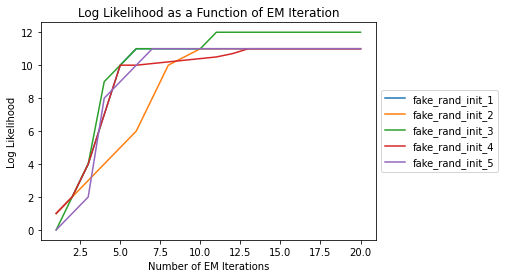

In [ ]:
import matplotlib.pyplot as plt

iterations = 20

# Create list containing iteration number (x-axis)
num_iterations = []
# Use range (1, iterations+1) since Python uses 0-based indexing
for i in range(1, iterations+1):
  num_iterations.append(i)

# Make a plot where the x-axis is the number of iterations
# and the y-axis contains the log likelihoods
plt.plot(num_iterations, fake_rand_init_1, label = "fake_rand_init_1")
plt.plot(num_iterations, fake_rand_init_2, label = "fake_rand_init_2")
plt.plot(num_iterations, fake_rand_init_3, label = "fake_rand_init_3")
plt.plot(num_iterations, fake_rand_init_4, label = "fake_rand_init_4")
plt.plot(num_iterations, fake_rand_init_5, label = "fake_rand_init_5")

# Assign axis titles, plot titles, and legend
plt.title('Log Likelihood as a Function of EM Iteration')
plt.xlabel('Number of EM Iterations')
plt.ylabel('Log Likelihood')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Generate plot
plt.show()

## 2. Draw a sequence logo visualization of the foreground motif your model learns, $\psi^{l}_{m, k}$. You could try LogoMaker, a Python library (https://logomaker.readthedocs.io/en/latest/). Alternatively, there are a number of web servers for doing this; you could draw samples from your foreground model, and input those drawn sequences into e.g. the WebLogo server (https://weblogo.berkeley.edu).

## 3. Now run your model using model random initializations. How do the model parameters $\psi^{l}_{m, k}$ compare across runs? What about their log likelihoods?

## 4. Plot a figure that shows the distribution over $C_{ij}$ for a few of the input sequences, and compare that (in the visualization) to the ground truth. How close was your model to predicting the real motif location?

## 5. Train your model using 80% of the data, holding out the remaining 20%. Evaluate the log likelihood of your held out data using the model you implemented in this assignment, and compare it to the log likelihood from the simple latent model we used in class, using the same training/held out data. Which one is better?

## 6. Train your model on the atgcsequences.txt file (that had a GC-rich region embedded between two flanking AT-rich regions). Does the model work better?

## 7. The original training set in sequence.padded.txt has 357 sequences. Randomly sample another 357 sequences of the same length (just from a simple generator, that produces each base at equal frequency) and train the model with all data. Does it still recover the same motif? What if you add 3000 noisy sequences?

Generate 357 sequences of the same length that produces each base at equal frequency.

In [ ]:
import random

# Number of sequences to generate
seqs = 357
# The minimum sequence length
min = 40
# The maximum sequence length
max = 40
# GC-content as a proportion
gc = 0.5

assert(seqs > 0)
assert(min > 0)
assert(max >= min)
assert(gc >= 0 and gc <= 1)

# Use probabilities for random sequence generation
# This does not guarantee that all bases are present at equal frequency
# But this means the sequence length does not have to be divisible by 4
# And base pair frequencies are close to equal
my_seqs = []
for i in range(seqs):
    l = random.randint(min, max)
    seq = []
    for j in range(l):
        r = random.random()
        if r < gc:
            r = random.random()
            if r < 0.5: seq.append('G')
            else:       seq.append('C')
        else:
            r = random.random()
            if r < 0.5: seq.append('A')
            else:       seq.append('T')
    my_seqs.append(''.join(seq))

print(my_seqs)